In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from data.input_data import time_opticaldensity_ph_glucose_protein

In [70]:
# Початкові значення
init = {
    "X": time_opticaldensity_ph_glucose_protein["OpticalDensity"].iloc[0],
    "pH": time_opticaldensity_ph_glucose_protein["pH"].iloc[0],
    "G": time_opticaldensity_ph_glucose_protein["Glucose"].iloc[0],
    "B": time_opticaldensity_ph_glucose_protein["Protein"].iloc[0]
}

# Константи (для прикладу)
initial_params = {
    'beta': [0.6, 0.3, 0.05, 0.02],  # X, pH, G, B
    'gamma': [0.3, 0.8, 0.4],        # gamma0, gamma1, gamma2
    'delta': [0.5],
    'eta': [0.3, 0.1]
}


In [71]:
# Для простоти зовнішні впливи (Stirring, Temp, Aeration) поки не включаємо

# for temp in [37, 38, 40]:
#     X_next = (initial_params['beta'][0] * X_t + initial_params['beta'][1] * pH_t + initial_params['beta'][2] * G_t + initial_params['beta'][3] * B_t)  # (37*C)

timesteps = len(time_opticaldensity_ph_glucose_protein)
results = {'X': [init['X']], 'pH': [init['pH']], 'Glucose': [init['G']], 'Protein': [init['B']]}

for t in range(timesteps - 1):
    # Add new external initial_parameters: temp, stirring, aeration to each equation
    X_t, pH_t, G_t, B_t = results['X'][-1], results['pH'][-1], results['Glucose'][-1], results['Protein'][-1]
    # Biomass
    X_next = (
        initial_params['beta'][0] *
        X_t + initial_params['beta'][1] *
        pH_t + initial_params['beta'][2] *
        G_t + initial_params['beta'][3] *
        B_t
    )  # (external initial_params)
    # pH
    pH_next = initial_params['gamma'][0] + initial_params['gamma'][1] * pH_t - initial_params['gamma'][2] * X_t
    # Glucose
    G_next = G_t - initial_params['delta'][0] * X_t
    # Protein
    B_next = B_t + initial_params['eta'][0] * X_t - initial_params['eta'][1] * B_t

    results['X'].append(X_next)
    results['pH'].append(pH_next)
    results['Glucose'].append(G_next)
    results['Protein'].append(B_next)

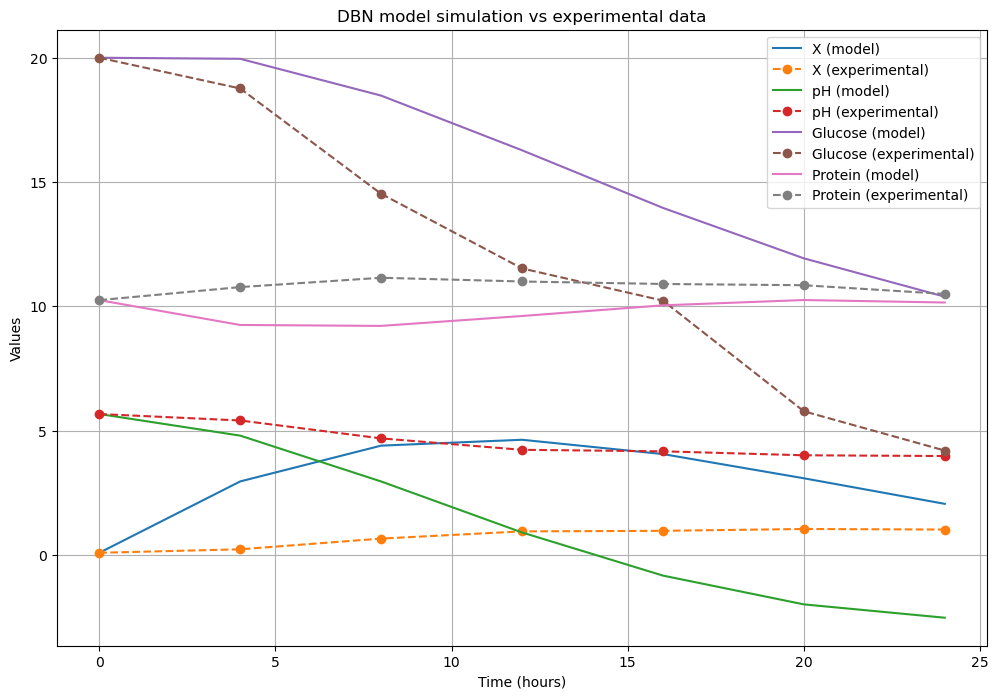

In [72]:
# Побудова графіків
plt.figure(figsize=(12, 8))
for key in results:
    plt.plot(time_opticaldensity_ph_glucose_protein["Time"], results[key], label=key + ' (model)')
    plt.plot(time_opticaldensity_ph_glucose_protein["Time"], time_opticaldensity_ph_glucose_protein[key if key != 'X' else 'OpticalDensity'], 'o--', label=key + ' (experimental)')

plt.xlabel('Time (hours)')
plt.ylabel('Values')
plt.legend()
plt.title('DBN model simulation vs experimental data')
plt.grid()
plt.show()

## Optimization part

In [73]:
def simulate(params, temperature: float = 1.0) -> tuple[np.ndarray, ...]:
    """
    Simulate system dynamics.
    temperature: scalar multiplier applied to the X_next equation (default 1.0).
    Returns arrays (X, pH, G, B) over time.
    """
    Xs, pHs, Gs, Bs = (
        [time_opticaldensity_ph_glucose_protein["OpticalDensity"].iloc[0]],
        [time_opticaldensity_ph_glucose_protein["pH"].iloc[0]],
        [time_opticaldensity_ph_glucose_protein["Glucose"].iloc[0]],
        [time_opticaldensity_ph_glucose_protein["Protein"].iloc[0]]
    )
    timestamps = len(time_opticaldensity_ph_glucose_protein) - 1

    for _ in range(timestamps):
        X, pH, G, B = Xs[-1], pHs[-1], Gs[-1], Bs[-1]

        # Apply temperature multiplier to the rate-like X_next equation
        X_next = (params[0] * X + params[1] * pH + params[2] * G + params[3] * B) * temperature
        pH_next = params[4] + params[5] * pH - params[6] * X
        G_next = G - params[7] * X
        B_next = B + params[8] * X - params[9] * B
        
        Xs.append(X_next)
        pHs.append(pH_next)
        Gs.append(G_next)
        Bs.append(B_next)
    return np.array(Xs), np.array(pHs), np.array(Gs), np.array(Bs)


def loss(params):
    # Keep baseline behavior: temperature defaults to 1.0
    X_pred, pH_pred, G_pred, B_pred = simulate(params)
    err = (
        np.sum((X_pred - time_opticaldensity_ph_glucose_protein["OpticalDensity"].values)**2) +
        np.sum((pH_pred - time_opticaldensity_ph_glucose_protein["pH"].values)**2) +
        np.sum((G_pred - time_opticaldensity_ph_glucose_protein["Glucose"].values)**2) +
        np.sum((B_pred - time_opticaldensity_ph_glucose_protein["Protein"].values)**2)
    )
    return err


# Початкове наближення
params = np.array([0.6, 0.3, 0.05, 0.02, 0.01, 0.01, 0.01, 0.3, 0.8, 0.4])

res = minimize(loss, params, method='L-BFGS-B', options={'maxiter': 10000})
print('Optimal params:', res.x)

Optimal params: [-0.32638092  0.44269195 -0.04864706 -0.05935535  1.96843011  0.63847865
  1.06425104  5.25155633 -1.34715631 -0.07600683]


## Temperature coefficients

  1) m_fit(35.0°C) = 0.976458
  2) m_fit(37.0°C) = 1.000000
  3) m_fit(40.0°C) = 0.950491
  4) m_fit(45.0°C) = 0.814320

In [74]:
# Baseline (temperature=1.0)
X_model, pH_model, G_model, B_model = simulate(res.x)

# Example: run with a different temperature multiplier (e.g., 0.9)
X_model_t09, pH_model_t09, G_model_t09, B_model_t09 = simulate(res.x, temperature=0.9)

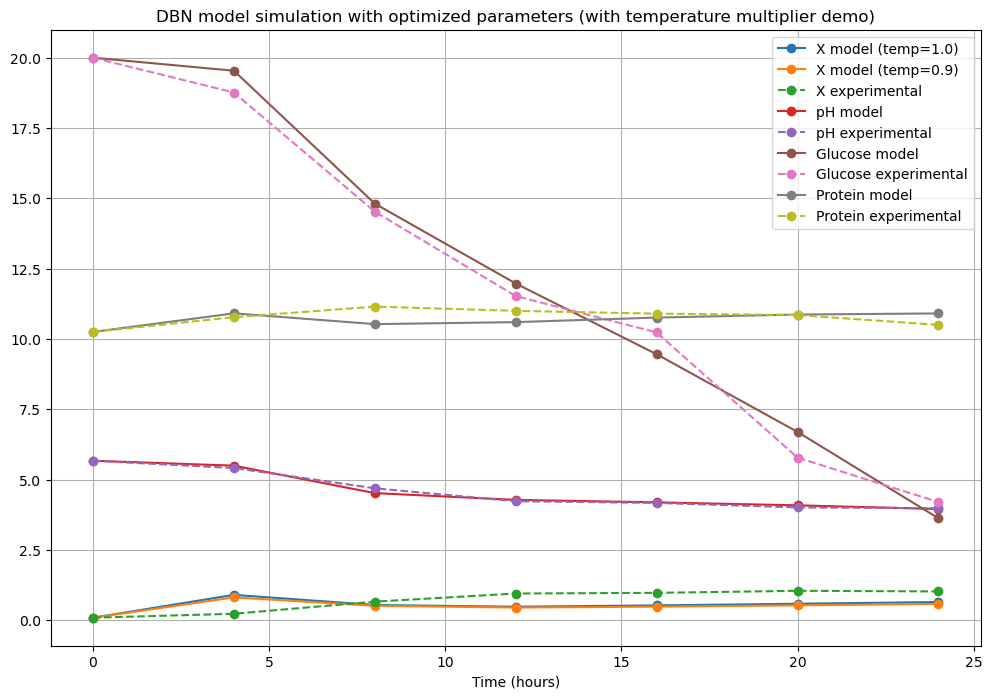

In [75]:
# Plot
plt.figure(figsize=(12, 8))
plt.plot(time_opticaldensity_ph_glucose_protein['Time'], X_model, label='X model (temp=1.0)', marker='o')
plt.plot(time_opticaldensity_ph_glucose_protein['Time'], X_model_t09, label='X model (temp=0.9)', marker='o')
plt.plot(time_opticaldensity_ph_glucose_protein['Time'], time_opticaldensity_ph_glucose_protein['OpticalDensity'], 'o--', label='X experimental')

plt.plot(time_opticaldensity_ph_glucose_protein['Time'], pH_model, label='pH model', marker='o')
plt.plot(time_opticaldensity_ph_glucose_protein['Time'], time_opticaldensity_ph_glucose_protein['pH'], 'o--', label='pH experimental')
plt.plot(time_opticaldensity_ph_glucose_protein['Time'], G_model, label='Glucose model', marker='o')
plt.plot(time_opticaldensity_ph_glucose_protein['Time'], time_opticaldensity_ph_glucose_protein['Glucose'], 'o--', label='Glucose experimental')
plt.plot(time_opticaldensity_ph_glucose_protein['Time'], B_model, label='Protein model', marker='o')
plt.plot(time_opticaldensity_ph_glucose_protein['Time'], time_opticaldensity_ph_glucose_protein['Protein'], 'o--', label='Protein experimental')

plt.legend()
plt.xlabel('Time (hours)')
plt.title('DBN model simulation with optimized parameters (with temperature multiplier demo)')
plt.grid()
plt.show()